# HiMAP tutorial: human data

This tutorial assumes you've installed HiMAP.

To test, download files from 2 samples of DIABIMMUNE Tri-county cohort:
* [Sample G3225 (forward)](https://pubs.broadinstitute.org/diabimmune/data/10/G63225_R1_001.fastq.gz)
* [Sample G3225 (reverse)](https://pubs.broadinstitute.org/diabimmune/data/10/G63225_R2_001.fastq.gz)
* [Sample G3228 (forward)](https://pubs.broadinstitute.org/diabimmune/data/10/G63228_R1_001.fastq.gz)
* [Sample G3228 (reverse)](https://pubs.broadinstitute.org/diabimmune/data/10/G63228_R2_001.fastq.gz)

and save them to a folder. For the purposes of this tutorial, we will save them to `~/data/diabimmune/fastq_tutorial/`. In these samples, V4 hyper-variable region is sequenced.

In [1]:
library(himap)

HiMAP v1.0 loaded.


## Loading files and specifying folders

First, we will need full paths to the FASTQ files for pair-end 16S reads. Filenames for all forwards reads will be stored in `fq_fwd` and reverse in `fq_rev`.

In [2]:
fastq_path = '~/data/diabimmune/tutorial/fastq'
fq_fwd = read_files(fastq_path, 'R1')
fq_rev = read_files(fastq_path, 'R2')

The filenames are used to extract identifiers for each file, either with forward or reverse reads. The function `sampleids_from_filenames` will retrieve those, given a separator (default is the underscore _). For example, from forward files: 

In [3]:
head(fq_fwd)

[1] "/Users/igor/data/diabimmune/tutorial/fastq/G63225_R1_001.fastq.gz"
[2] "/Users/igor/data/diabimmune/tutorial/fastq/G63228_R1_001.fastq.gz"

we would like `G63225` and `G63228` labels:

In [4]:
sample_ids = sampleids_from_filenames(fq_fwd, separator='_')
head(sample_ids)

[1] "G63225" "G63228"

HiMAP will output a number of output files and folders, which will be explained as we go along, so specify a folder where to save all files:

In [5]:
out_path = path.expand('~/data/diabimmune/tutorial')

## Merging reads

First specify the output files for each sample, the merge:

In [6]:
fq_mer = file.path(out_path, 'merged', paste0(sample_ids, '.fastq'))
mergestats = merge_pairs(fq_fwd, fq_rev, fq_mer, verbose=T)

Loading FASTQ reads... OK.
Merging pairs... OK.
Writing output files... OK.
Loading FASTQ reads... OK.
Merging pairs... OK.
Writing output files... OK.


Check how many reads are merged and not merged:

In [7]:
colnames(mergestats) = sample_ids
mergestats

,G63225,G63228
total,107153,129781
low_pct_sim,1264,989
low_aln_len,6,20


Out of 107,153 total reads 1,264 were not merged due to low percentage similarity in the alignment (if this number is high, consider lowering `min_sim` parameter) or too high alignment length (if this number is too high, consider lowering `low_aln_len`). See `?merge_pairs` for more details.

## Trim PCR primers

Trim PCR primers from merged reads. Specify region 'V4' or 'V3-V4'. First, create output filenames, then do the trimming, using V4 region primers. Exact primer sequences can also be specified using arguments `pr_fwd` and `pr_rev`; see `?pcr_primer_trimmer` for details.

In [8]:
fq_tri = file.path(out_path, 'trimmed', paste0(sample_ids, '.fastq'))
trimstats = pcr_primer_trimmer(fq_mer, fq_tri, region='V4')

In [9]:
colnames(trimstats) = sample_ids
trimstats

,G63225,G63228
fwd_trim,0,0
rev_trim,0,0


No primers were found in this dataset.

## Quality control and fixed-length trimming

Since the input for DADA2 denoising requires all sequences to be trimmed to the fixed length, we first inspect the distribution of sequence lengths before choosing this parameter:

In [10]:
seqlen.ft = sequence_length_table(fq_tri)

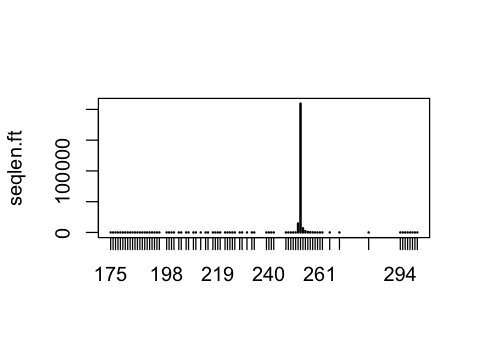

In [11]:
options(repr.plot.width=4, repr.plot.height=3) # Make a smaller plot
plot(seqlen.ft)

We can select the minimum trimming length by finding the length above which we have 99% of the reads, since most of the reads here have 252 and 253 nt length.

In [12]:
trim_length = ftquantile(seqlen.ft, 0.01)
trim_length

[1] 252

Now we can use that to do the trimming. For quality control keep sequences with 2 or less expected errors [Edgar, Flyberg]. This also removes any phiX sequences and sequences containing any Ns after truncation (trimming):

In [13]:
fq_fil = file.path(out_path, 'filtered', paste0(sample_ids, '.fastq'))
filtstats = dada2::filterAndTrim(fq_tri, fq_fil, truncLen=trim_length, maxEE=2, multithread=T, verbose=T)

As before, the function returns the table showing the number of reads kept during the QC filtering process:

In [14]:
filtstats

,reads.in,reads.out
G63225.fastq,105889,98352
G63228.fastq,128782,122382


## Denoising

For denoising, we use `dada` function from the dada2 package. After the denoising part is done, for each partition, we retrieve pre-trimmed sequences and add their consensus sequence back. This can improve the accuracy of the alignment to the reference database in one of the next steps.

In [15]:
# dada_result = dada_denoise(fq_fil, fq_tri)
dada_result = readRDS(file.path(out_path, 'dada_result'))

In [16]:
# saveRDS(dada_result, file.path(out_path, 'dada_result'))

## Count sequences, remove bimeras, collapse sequences from multiple samples

Next, we count the number of reads for each denoised sequence, remove chimeric (here bimeric) reads. If we work with multiple samples, we pool together denoised sequences that are identical up to shifts or length variation:

In [17]:
ab.dt = sequence_abundance(dada_result)

* generating sequence table...

The sequences being tabled vary in length.


 OK.
* removing bimeras...

Identified 1186 bimeras out of 1703 input sequences.


 OK.
* adding together sequences that differ in shifts on lengths...collapse:
* generating temporary files...OK.
* blast word size: 202 
* running blast...blast status:  0
OK.
* selecting ends-free alignments...OK.
* no sequences need collapsing.
* cleaning up temporary files...OK.
* returning input.
 OK.


In [18]:
head(ab.dt, 10)

sample_id,qseqid,raw_count,sequence
G63225,1,25291,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGATGTCTTGAGTGCAGTTGAGGCAGGCGGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATCACGAAGAACTCCGATTGCGAAGGCAGCCTGCTAAGCTGCAACTGACATTGAGGCTCGAAAGTGTGGGTATCAAACAGG
G63228,1,31,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGATGTCTTGAGTGCAGTTGAGGCAGGCGGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATCACGAAGAACTCCGATTGCGAAGGCAGCCTGCTAAGCTGCAACTGACATTGAGGCTCGAAAGTGTGGGTATCAAACAGG
G63225,2,0,TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTGCGTAGGCTGTTTCGTAAGTCGTGTGTGAAAGGCGCGGGCTCAACCCGCGGACGGCACATGATACTGCGAGACTAGAGTAATGGAGGGGGAACCGGAATTCTCGGTGTAGCAGTGAAATGCGTAGATATCGAGAGGAACACTCGTGGCGAAGGCGGGTTCCTGGACATTAACTGACGCTGAGGCACGAAGGCCAGGGGAGCGAAAGGG
G63228,2,23187,TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTGCGTAGGCTGTTTCGTAAGTCGTGTGTGAAAGGCGCGGGCTCAACCCGCGGACGGCACATGATACTGCGAGACTAGAGTAATGGAGGGGGAACCGGAATTCTCGGTGTAGCAGTGAAATGCGTAGATATCGAGAGGAACACTCGTGGCGAAGGCGGGTTCCTGGACATTAACTGACGCTGAGGCACGAAGGCCAGGGGAGCGAAAGGG
G63225,3,815,AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCTATGGGCTCAACCCATAAACTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGGCGGAATTCCCGGTGTAGCGGTGGAATGCGTAGATATCGGGAGGAACACCAGTGGCGAAGGCGGCCTACTGGGCACCAACTGACGCTGAGGCTCGAAAGTGTGGGTAGCAAACAGG
G63228,3,9908,AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCTATGGGCTCAACCCATAAACTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGGCGGAATTCCCGGTGTAGCGGTGGAATGCGTAGATATCGGGAGGAACACCAGTGGCGAAGGCGGCCTACTGGGCACCAACTGACGCTGAGGCTCGAAAGTGTGGGTAGCAAACAGG
G63225,4,403,TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGGCGGTGCGGCAAGTCTGATGTGAAAGCCCGGGGCTCAACCCCGGTACTGCATTGGAAACTGTCGTACTAGAGTGTCGGAGGGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACGATAACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAACAGG
G63228,4,8392,TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGGCGGTGCGGCAAGTCTGATGTGAAAGCCCGGGGCTCAACCCCGGTACTGCATTGGAAACTGTCGTACTAGAGTGTCGGAGGGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACGATAACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAACAGG
G63225,5,0,TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGGAGATTAAGCGTGTTGTGAAATGTAGACGCTCAACGTCTGCACTGCAGCGCGAACTGGTTTCCTTGAGTACGCACAAAGTGGGCGGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATCACGAAGAACTCCGATTGCGAAGGCAGCTCACTGGAGCGCAACTGACGCTGAAGCTCGAAAGTGCGGGTATCGAACAGG
G63228,5,7915,TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGGAGATTAAGCGTGTTGTGAAATGTAGACGCTCAACGTCTGCACTGCAGCGCGAACTGGTTTCCTTGAGTACGCACAAAGTGGGCGGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATCACGAAGAACTCCGATTGCGAAGGCAGCTCACTGGAGCGCAACTGACGCTGAAGCTCGAAAGTGCGGGTATCGAACAGG


## Align sequences vs reference database

Now that we have a final list of sequences, we align these sequences to the reference database. We BLAST these sequences against our V4 region HiMAP database:

In [19]:
blast_output_file = file.path(out_path, 'blast_vs_db.txt')
blast_output = blast(ab.dt, blast_output_file, region='V4', max_target_seqs=100,
                     word_size=50, verbose=T)

* blast input type: abundance table
* blast out: OK. blast best: OK. copy number table: OK.
merge: OK. Fix overhang differences:..OK. OK.


## Calculate OSU abundances

We then use sequence abundance table `ab.dt` and `blast_output` to infer OSUs: 

In [20]:
osu_ab.dt = abundance(ab.dt, blast_output)

OSU table: OK. Melt table:  OK.Preparing blast tables...OK.


In [21]:
head(osu_ab.dt, 10)

sample_id,osu_id,osu_count,pctsim,species
G63225,2937,8430,100.00,"Bacteroides_dorei_[8],Bacteroides_sp._3_1_33FAA,Bacteroides_sp._9_1_42FAA"
G63225,3368,7138,100.00,"Bacteroides_ovatus_[4],Bacteroides_sp._KFT8"
G63225,1000009,4078,95.26,Ruminococcus_bicirculans_80/3
G63225,2719,3881,100.00,"Burkholderiales_bacterium_1_1_47,Parasutterella_excrementihominis_YIT_11859"
G63225,2884,2130,100.00,Alistipes_putredinis_[2]
G63225,3048,2098,100.00,Dialister_invisus_[3]
G63225,6895,1976,100.00,Oscillibacter_sp._ER4
G63225,5756,1862,100.00,"Oscillibacter_sp._KLE_1728,Oscillibacter_sp._KLE_1745,Oscillospiraceae_bacterium_VE202-24"
G63225,7842,1743,100.00,Faecalibacterium_prausnitzii_[2]
G63225,1000022,1587,99.60,"Burkholderiales_bacterium_1_1_47,Parasutterella_excrementihominis_YIT_11859"


In [22]:
write_table(osu_ab.dt, file.path(out_path, 'osu_abundances.txt'))

## Add taxonomy

For each OSU, we get taxonomic ranks for all detected strains, from NCBI Taxonomy database.

In [23]:
osu_tax.dt = taxonomy(osu_ab.dt)

In [24]:
head(osu_tax.dt, 10)

osu_id,pctsim,phylum,class,order,family,genus
1000262,90.12,Firmicutes_[2],Clostridia_[2],Clostridiales_[2],"Lachnospiraceae_[1],Defluviitaleaceae_[1]","Abyssivirga_[1],Vallitalea_[1]"
1000416,84.13,Firmicutes_[1],Clostridia_[1],Clostridiales_[1],Peptostreptococcaceae_[1],Acetoanaerobium_[1]
1000159,87.30,Tenericutes_[1],Mollicutes_[1],Acholeplasmatales_[1],Acholeplasmataceae_[1],Acholeplasma_[1]
164,100.00,Proteobacteria_[8451],"Gammaproteobacteria_[8450],Betaproteobacteria_[1]","Enterobacterales_[8449],Burkholderiales_[1],Vibrionales_[1]","Enterobacteriaceae_[8448],Alcaligenaceae_[1],Pectobacteriaceae_[1],Vibrionaceae_[1]","Escherichia_[7472],Shigella_[974],Achromobacter_[1],Brenneria_[1],Citrobacter_[1],Klebsiella_[1],Vibrio_[1]"
2498,100.00,Proteobacteria_[187],"Gammaproteobacteria_[186],Betaproteobacteria_[1]","Enterobacterales_[186],Burkholderiales_[1]","Enterobacteriaceae_[186],Alcaligenaceae_[1]","Klebsiella_[147],Enterobacter_[30],Salmonella_[6],Citrobacter_[3],Achromobacter_[1]"
1022,100.00,"Firmicutes_[1236],Proteobacteria_[1]","Bacilli_[1236],Gammaproteobacteria_[1]","Lactobacillales_[1236],Pseudomonadales_[1]","Enterococcaceae_[1235],Moraxellaceae_[1],Lactobacillaceae_[1]","Enterococcus_[1235],Acinetobacter_[1],Lactobacillus_[1]"
1000353,99.21,Actinobacteria_[3],Actinobacteria_[3],Actinomycetales_[3],Actinomycetaceae_[3],Actinomyces_[3]
2873,100.00,Actinobacteria_[19],Actinobacteria_[19],"Actinomycetales_[13],Micrococcales_[6]","Actinomycetaceae_[13],Promicromonosporaceae_[2],Dermacoccaceae_[2],Cellulomonadaceae_[1],Sanguibacteraceae_[1]","Actinomyces_[13],Kytococcus_[2],Cellulomonas_[1],Isoptericola_[1],Sanguibacter_[1],Xylanimonas_[1]"
6834,100.00,Actinobacteria_[3],Actinobacteria_[3],Actinomycetales_[3],Actinomycetaceae_[3],Actinomyces_[3]
1000051,96.44,Firmicutes_[2],Clostridia_[2],Clostridiales_[2],Ruminococcaceae_[2],"Acutalibacter_[1],Ruminiclostridium_[1]"
